In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [4]:
# We care primarily about UGDS and it's variants
# admission indicators such as ADM_RATE, SAT, and ACT scores.
# student sucuess measures RET_FT4, C150_4)
# cost measures such as (TUITIONFEE_IN, TUITIONFEE_OUT and related financial measures)

In [5]:
df_combined_scorecard = pd.read_csv("combined_scorecard_data.csv")
df_football_records = pd.read_csv("college_football_records.csv")

In [6]:
df_football_records.head()

,team,year,won,lost,tied,notes,scorecard_name
0,Air_Force,2023,9.0,4.0,NaN,NaN,United States Air Force Academy
1,Air_Force,2022,10.0,3.0,NaN,NaN,United States Air Force Academy
2,Air_Force,2021,10.0,3.0,NaN,NaN,United States Air Force Academy
3,Air_Force,2020,3.0,3.0,NaN,NaN,United States Air Force Academy
4,Air_Force,2019,11.0,2.0,NaN,NaN,United States Air Force Academy


In [7]:
# Unit ID = Institution ID (int)
# OPEID = 8-digit OPE ID for institution (str)
# INSTNM = Institution name (str)
# CITY = City (str)
# Year = year (int)
# UGDS = ???
# Main = flag for main campus ("Not main campus", "main campus")
# NumBranch = number of branch campuses (int)
# HighDeg = highest degree awarded by institution (0 - 4) 
# -> 0 = no degree, 1 = certificate, 2 = associate, 3 = bachelor's, 4 = graduate
# Region = (IPEDS) (int)
# ADM_RATE = admission rate (float)
# ACTCMMID = Midpoint of the ACT cumulative score (float)
# SAT_AVG = average SAT score of students admitted (float)
# UGDS = enrollment of undergraduate students (float)
# UGDS_WHITE = enrollment of white students (float)
# UGDS_BLACK = enrollment of black students (float)
# UGDS_HISP = enrollment of hispanic students (float)
# UGDS_ASIAN = enrollment of asian students (float)
# TUITIONFEE_IN = in state tuition and fees
# TUITIONFEE_OUT = out of state tuition and fees
# AVGFACSAL = average faculty salary
# PFTFAC = full-time faculty rate
# PCTPELL = percentage of undergrad students receiving Pell grants
# C150_4 = completion rate for first-time, full-time students at 4-year institutions
# RET_FT4 = retention rate for first-time, full-time students at 4-year institutions
# MD_EARN_WNE_P10 = median earnings of students working and not enrolled 10 years after entry
# UGDS_MEN = share of undergraduate degree seeking men
# UGDS_WOMEN = share of undergraduate degree seeking women
# OPENADMP = open admission policy (1 = yes, 2 = no, 3 = no first-time students)
# BOOKSUPPLY = cost of attendance books and supplies
# ROOMBOARD_ON = cost of attendance room and board on campus
# OTHEREXPENSE_ON = estimated other on campus expenses
# ROOMBOARD_OFF = estimated cost of off campus room and board
# OTHEREXPENSE_OFF = estimated other off campus expenses
# ADMCON7 = Test score requirements for admissions (1 = required, 2 = recommended, 3 = neither, 4 = don't know, 5 = considered but not required)



In [8]:
# 1. Check missing values per column (count)
missing_counts = df_combined_scorecard.isnull().sum()
print("Missing values per column:")
print(missing_counts)

# 2. Calculate percentage of missing values per column
missing_percentage = df_combined_scorecard.isnull().mean() * 100
print("\nPercentage of missing values per column:")
print(missing_percentage)

# 3. Determine the cost of removing rows with any missing values
total_rows = df_combined_scorecard.shape[0]
df_clean = df_combined_scorecard.dropna()  # Drops any row with at least one NA value
rows_after_drop = df_clean.shape[0]
rows_removed = total_rows - rows_after_drop
print("\nCost of removing rows with missing values:")
print(f"Total rows: {total_rows}")
print(f"Rows after dropping missing values: {rows_after_drop}")
print(f"Rows removed: {rows_removed}")
print(f"Percentage of rows removed: {rows_removed / total_rows * 100:.2f}%")


Missing values per column:
UNITID                 0
OPEID                  0
INSTNM                 0
CITY                   0
Year                   0
UGDS                 206
MAIN                   0
NUMBRANCH              0
HIGHDEG                0
REGION                 0
LOCALE              4682
LOCALE2             4862
CCSIZSET            4682
PCTPELL             2212
AVGFACSAL            187
PFTFAC              1082
PRGMOFR             4862
BOOKSUPPLY           619
ROOMBOARD_ON         639
ROOMBOARD_OFF       1432
OTHEREXPENSE_ON      654
OTHEREXPENSE_OFF    1428
ADMCON7              738
MDCOST_ALL          4862
MDEARN_ALL          4862
UGDS_WOMEN           206
UGDS_MEN             206
ADM_RATE             985
SAT_AVG             1122
ACTCMMID            1496
RET_FT4             1480
C150_4               242
MD_EARN_WNE_P10     3629
TUITIONFEE_IN        790
TUITIONFEE_OUT       790
UGDS_WHITE          2175
UGDS_BLACK          2175
UGDS_HISP           2175
UGDS_ASIAN          217

In [9]:
# Since 95-100% missing, let's remove LOCALE, LOCALE2, CCSIZESET, PRGMOFR, MDCOST_ALL, MDEARN_ALL
# these variables represented:

# Locale (int) (city:large - rural:remote)
# Locale2 Degree of urbanization (int) (large city - rural, inside MSA)
# Carnegie Classification (Not applied - 18) (int)
# PRGMOFR = number of programs offered (int)
# MDCOST_ALL = Overall median for average net price
# MDEARN_ALL = Overall median earnings of students working and not enrolled 10 years after entry

In [10]:
columns_to_remove = ['LOCALE2', 'PRGMOFR', 'MDCOST_ALL', 'MDEARN_ALL', 'LOCALE', 'CCSIZSET']

df_combined_scorecard = df_combined_scorecard.drop(columns=columns_to_remove)

In [11]:
# Let's restrict years to the past 20 years, for clarity. Our years of interest will be (2002 - 2022)

df_combined_scorecard = df_combined_scorecard[(df_combined_scorecard['Year'] >= 2002) & (df_combined_scorecard['Year'] <= 2022)]

In [12]:
# List of variables of interest including school and year identifiers
columns_of_interest = [
    'UNITID', 'INSTNM', 'CITY', 'Year',
    'UGDS', 'UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN',
    'ADM_RATE', 'SAT_AVG', 'ACTCMMID',
    'RET_FT4', 'C150_4',
    'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'AVGFACSAL', 'PFTFAC',
    'BOOKSUPPLY', 'ROOMBOARD_ON', 'ROOMBOARD_OFF', 'OTHEREXPENSE_ON', 'OTHEREXPENSE_OFF'
]

df = df_combined_scorecard[columns_of_interest]


Summary statistics for numeric variables:
               UGDS   UGDS_WHITE   UGDS_BLACK    UGDS_HISP   UGDS_ASIAN  \
count   3761.000000  2687.000000  2687.000000  2687.000000  2687.000000   
mean   16332.428875     0.534938     0.069243     0.105105     0.070823   
std    10700.983916     0.253201     0.068350     0.122467     0.079625   
min        0.000000     0.000000     0.000000     0.000000     0.000000   
25%     7120.000000     0.409650     0.028900     0.038100     0.016100   
50%    15575.000000     0.611500     0.054100     0.072200     0.042400   
75%    22940.000000     0.733450     0.083300     0.120200     0.093500   
max    73189.000000     0.884000     0.423800     0.878200     0.409700   

          ADM_RATE      SAT_AVG    ACTCMMID      RET_FT4       C150_4  \
count  3706.000000  3575.000000  3247.00000  3382.000000  3739.000000   
mean      0.589010  1204.555245    26.21620     0.856483     0.687633   
std       0.249097   141.972594     3.63636     0.087820     0.

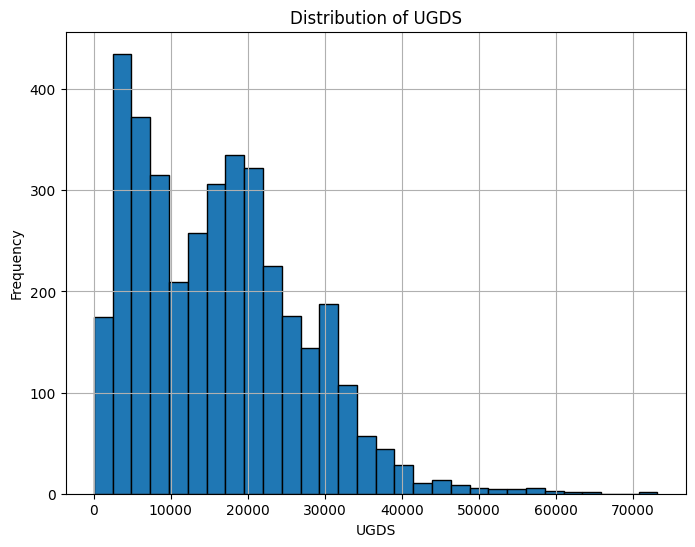

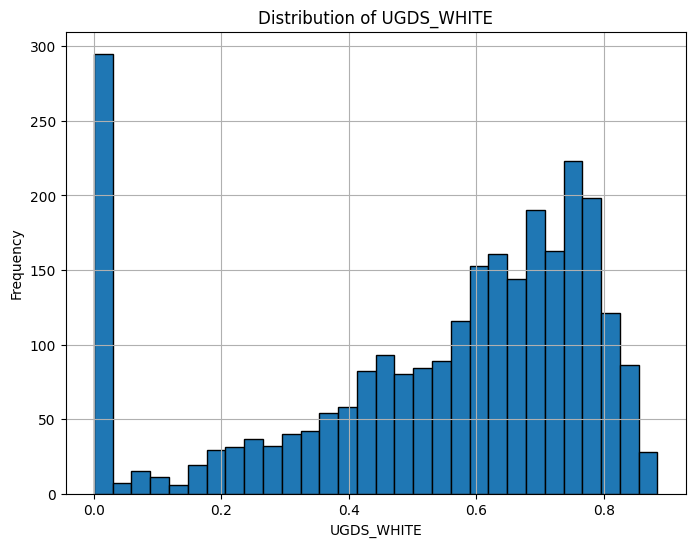

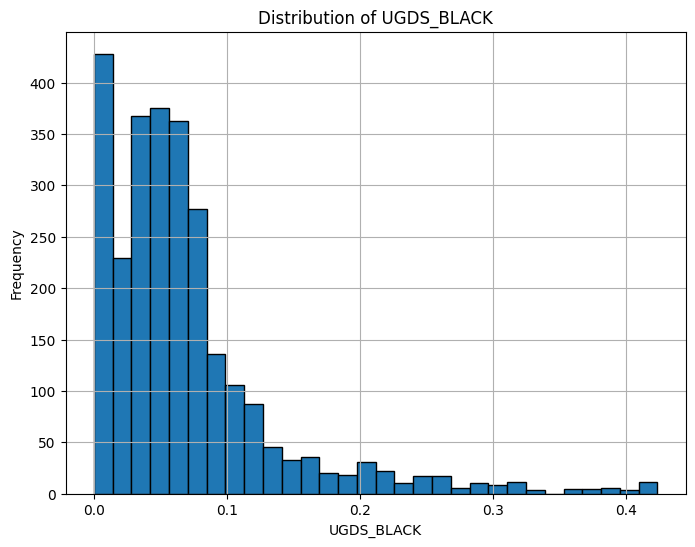

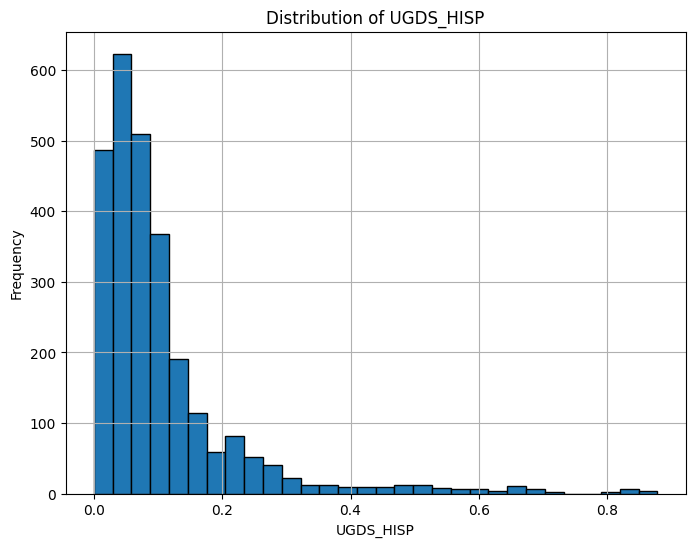

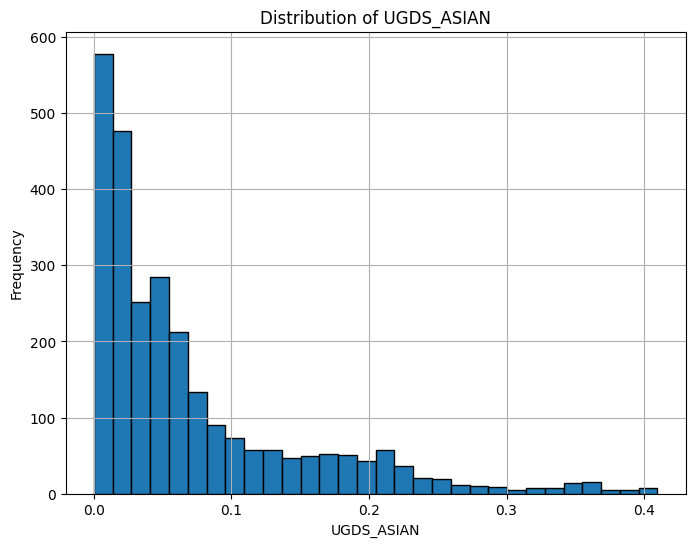

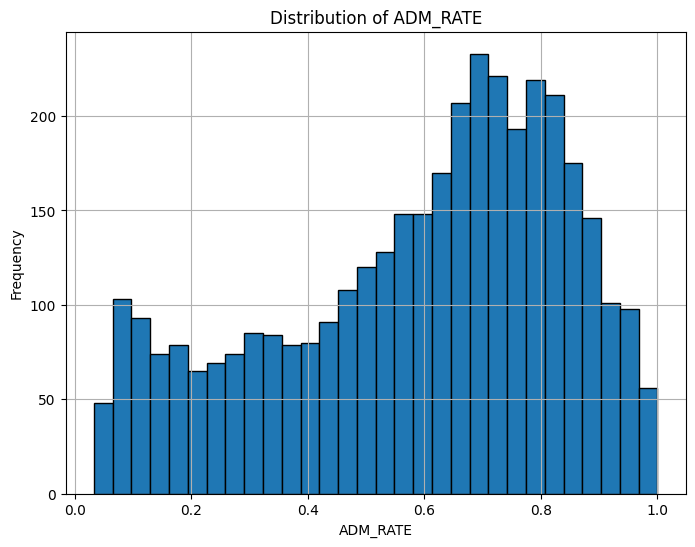

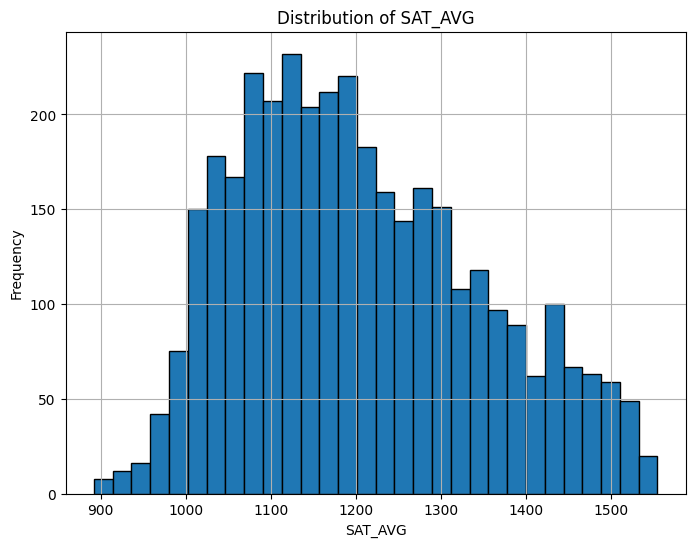

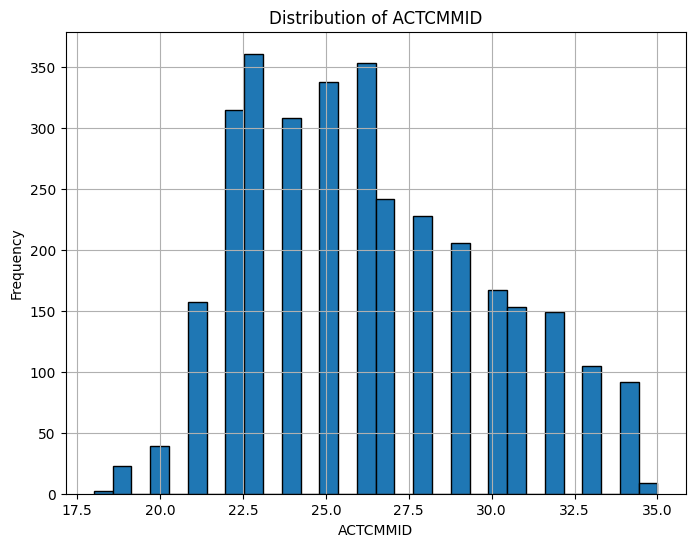

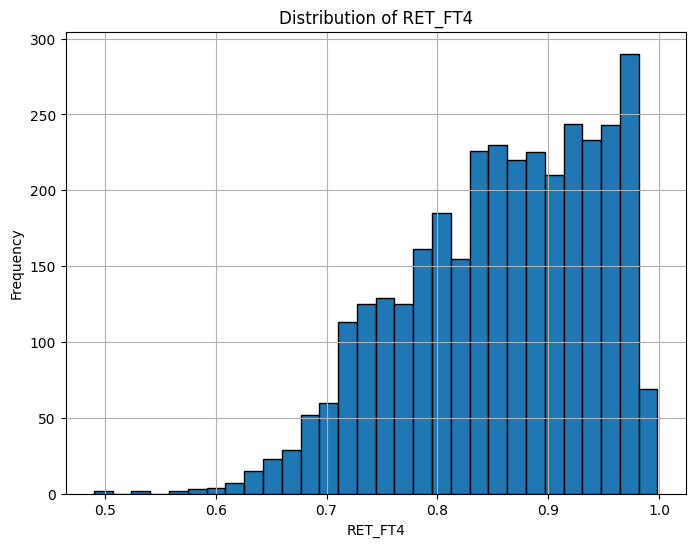

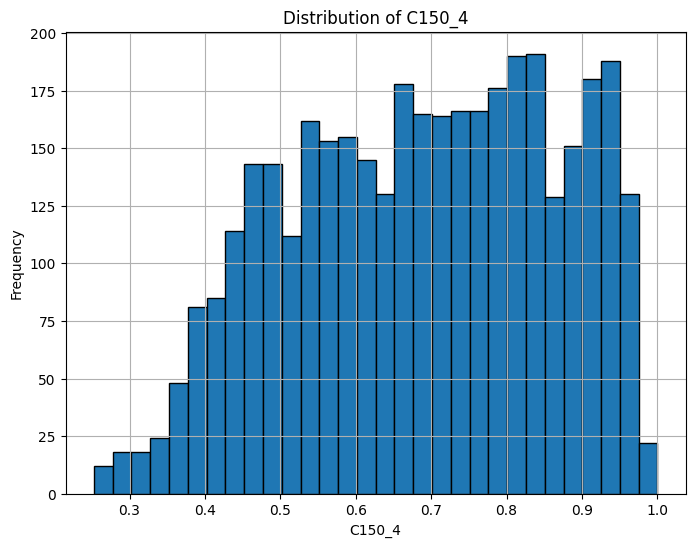

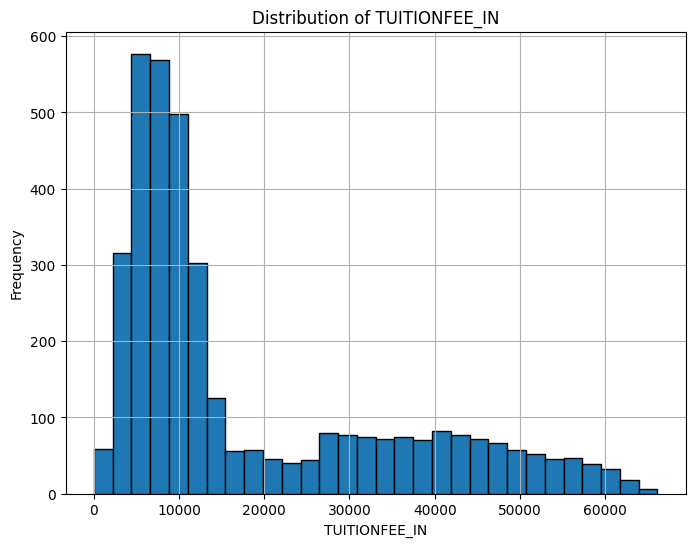

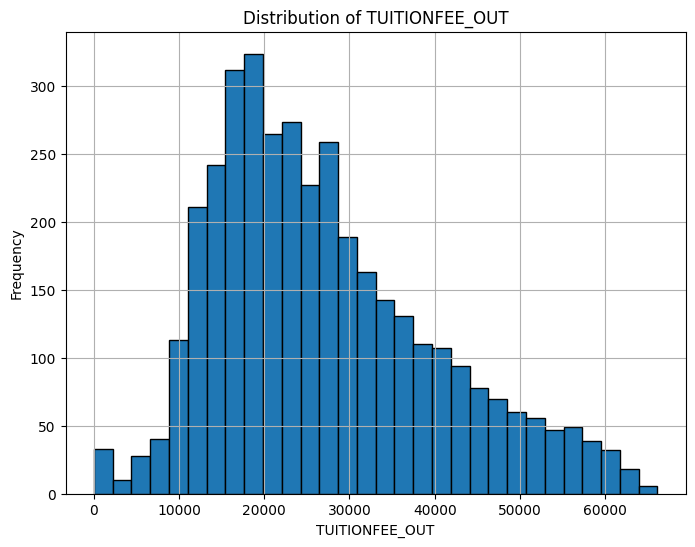

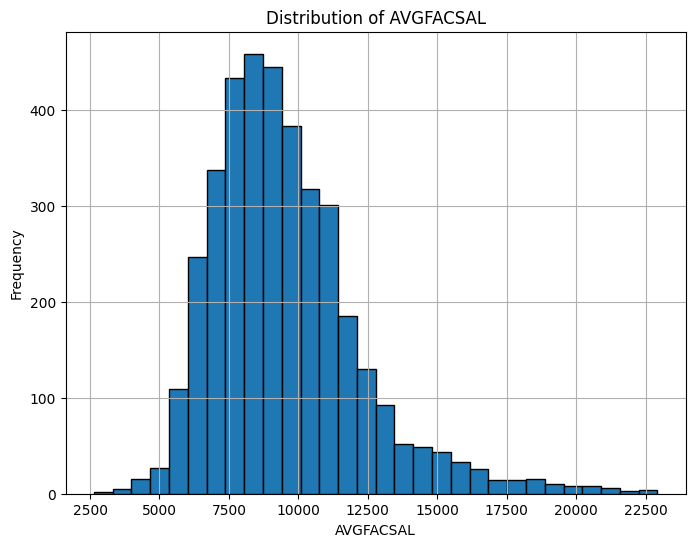

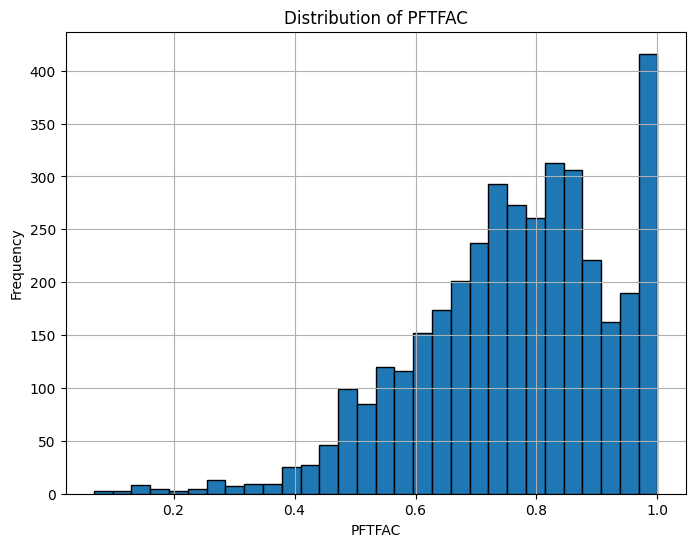

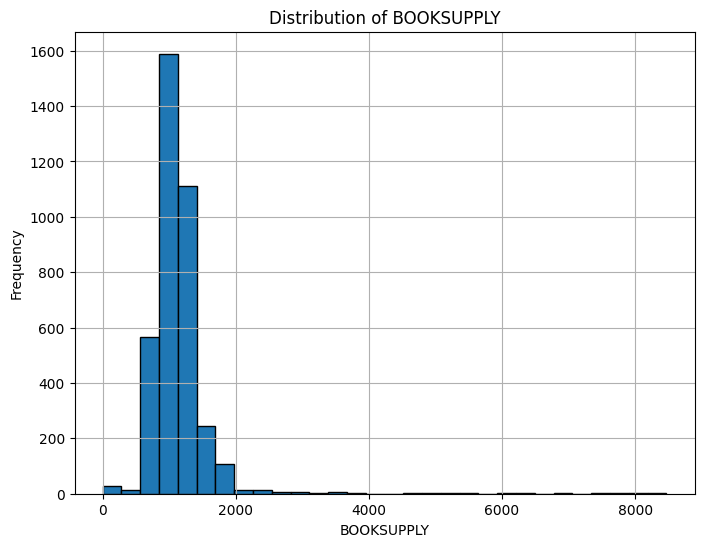

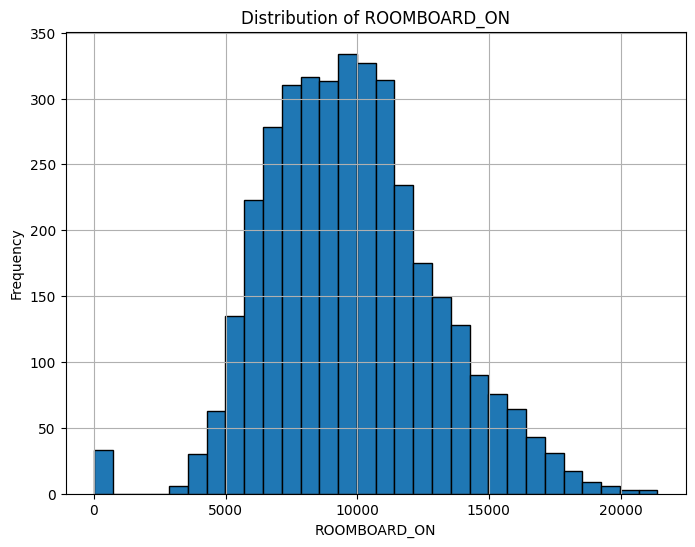

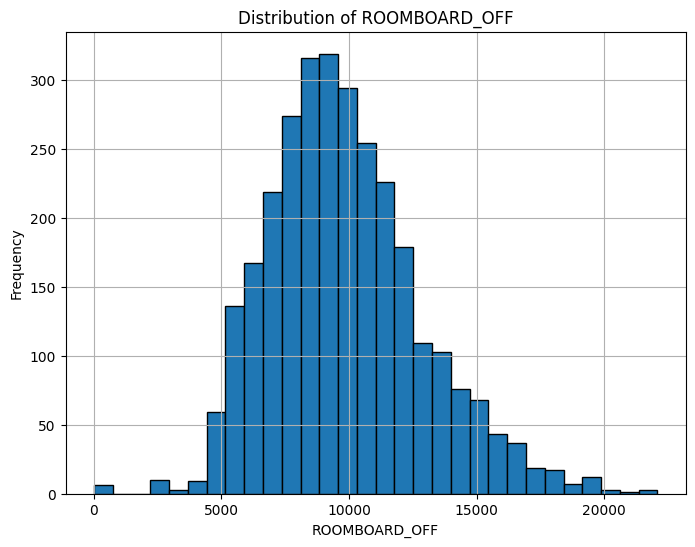

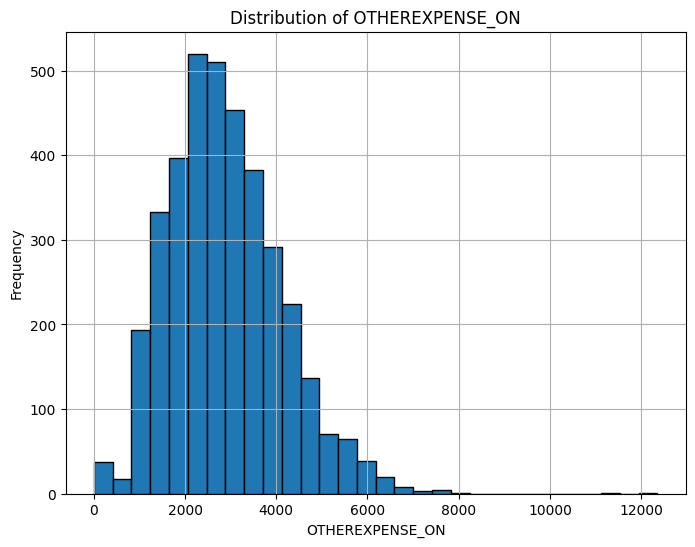

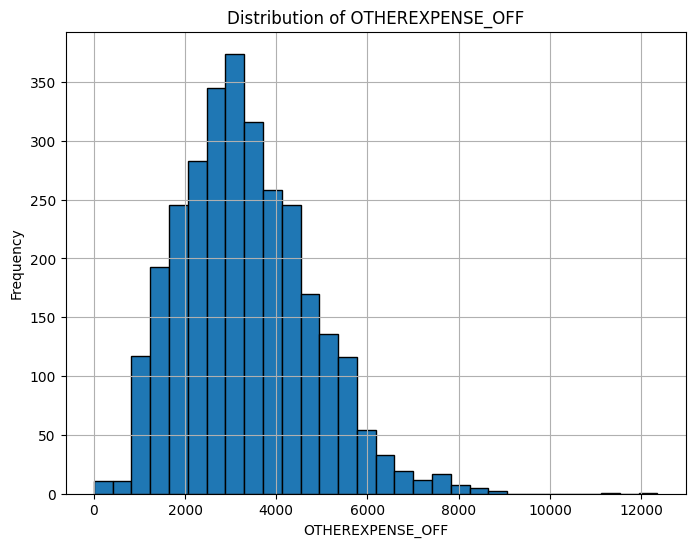

In [13]:
# determine how to resolve missing values
# we could use median imputation, or forward fill if more reasonable

numeric_vars = [
    'UGDS', 'UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN',
    'ADM_RATE', 'SAT_AVG', 'ACTCMMID',
    'RET_FT4', 'C150_4',
    'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'AVGFACSAL', 'PFTFAC',
    'BOOKSUPPLY', 'ROOMBOARD_ON', 'ROOMBOARD_OFF', 'OTHEREXPENSE_ON', 'OTHEREXPENSE_OFF'
]

print("Summary statistics for numeric variables:")
print(df[numeric_vars].describe())

# Loop through each variable and create a histogram
for var in numeric_vars:
    plt.figure(figsize=(8, 6))
    plt.hist(df[var].dropna(), bins=30, edgecolor='black')
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


In [14]:
df.sort_values(by=["UNITID", "Year"])

,UNITID,INSTNM,CITY,Year,UGDS,UGDS_WHITE,UGDS_BLACK,UGDS_HISP,UGDS_ASIAN,ADM_RATE,...,C150_4,TUITIONFEE_IN,TUITIONFEE_OUT,AVGFACSAL,PFTFAC,BOOKSUPPLY,ROOMBOARD_ON,ROOMBOARD_OFF,OTHEREXPENSE_ON,OTHEREXPENSE_OFF
1080,100663,University of Alabama at Birmingham,Birmingham,2002,9714.0,NaN,NaN,NaN,NaN,0.9117,...,0.3759,3880.0,7810.0,6917.0,0.9481,900.0,7218.0,7875.0,2438.0,3375.0
1260,100663,University of Alabama at Birmingham,Birmingham,2003,10381.0,NaN,NaN,NaN,NaN,0.8049,...,0.3857,4274.0,9494.0,6734.0,0.8990,900.0,8627.0,8823.0,2438.0,3375.0
1440,100663,University of Alabama at Birmingham,Birmingham,2004,10854.0,NaN,NaN,NaN,NaN,0.8592,...,0.3773,4662.0,10422.0,7398.0,0.9000,900.0,8743.0,8823.0,2438.0,3375.0
1620,100663,University of Alabama at Birmingham,Birmingham,2005,11060.0,NaN,NaN,NaN,NaN,0.8769,...,0.3587,4792.0,10732.0,7796.0,0.9258,900.0,8924.0,8904.0,2438.0,3375.0
1800,100663,University of Alabama at Birmingham,Birmingham,2006,10884.0,NaN,NaN,NaN,NaN,0.8778,...,0.3582,4792.0,10732.0,8232.0,0.9186,900.0,12266.0,11868.0,2438.0,3375.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4499,243780,Purdue University-Main Campus,West Lafayette,2020,35517.0,0.6351,0.0258,0.0598,0.1039,0.6715,...,0.8281,9992.0,28794.0,12677.0,0.9647,1000.0,10030.0,10520.0,1760.0,1760.0
4680,243780,Purdue University-Main Campus,West Lafayette,2021,37658.0,0.6276,0.0248,0.0625,0.1161,0.6881,...,0.8266,9992.0,28794.0,12911.0,0.9674,1010.0,10030.0,10030.0,1780.0,1780.0
4861,243780,Purdue University-Main Campus,West Lafayette,2022,38438.0,0.6110,0.0247,0.0662,0.1262,0.5270,...,0.8304,9992.0,28794.0,13441.0,0.9679,1050.0,10030.0,10030.0,1850.0,1850.0
4500,495767,The Pennsylvania State University,University Park,2020,73189.0,0.6513,0.0588,0.0815,0.0674,0.7827,...,0.7281,18450.0,35514.0,10822.0,0.8280,1840.0,12318.0,12318.0,4788.0,4788.0


In [15]:
head = df.sort_values(by="UNITID")

spliced_data = {unitid: head[head["UNITID"] == unitid] for unitid in head["UNITID"].unique()}

print(f"Total unique UNITIDs: {len(spliced_data)}")

Total unique UNITIDs: 181


In [16]:
print(spliced_data[list(spliced_data.keys())[2]]) 

      UNITID             INSTNM    CITY  Year     UGDS  UGDS_WHITE  \
1262  100858  Auburn University  Auburn  2003  19145.0         NaN   
3242  100858  Auburn University  Auburn  2014  20514.0      0.8507   
4684  100858  Auburn University  Auburn  2022  25234.0      0.8269   
4503  100858  Auburn University  Auburn  2021  24782.0      0.8181   
2522  100858  Auburn University  Auburn  2010  20221.0      0.8532   
3602  100858  Auburn University  Auburn  2016  22095.0      0.8285   
3422  100858  Auburn University  Auburn  2015  21551.0      0.8420   
2342  100858  Auburn University  Auburn  2009  19918.0      0.0000   
2882  100858  Auburn University  Auburn  2012  20137.0      0.8539   
3782  100858  Auburn University  Auburn  2017  23391.0      0.8180   
1082  100858  Auburn University  Auburn  2002  19456.0         NaN   
1802  100858  Auburn University  Auburn  2006  19349.0         NaN   
1622  100858  Auburn University  Auburn  2005  19222.0         NaN   
4142  100858  Auburn

In [17]:
missing_threshold = 0.5

# Dictionaries to store flagged and non-flagged datasets
flagged_data = {}  # Stores flagged datasets
non_flagged_data = {}  # Stores successfully processed datasets
flagged_datasets = []  # Stores details of flagged datasets

# Iterate over each unique UNITID dataset
for unitid, df in spliced_data.items():
    # Replace 0.000 with NaN
    df = df.replace(0.000, np.nan)

    # Select only numerical columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    # Check if any numerical column has excessive missing values
    cols_with_excessive_missing = [col for col in numeric_cols if df[col].isnull().mean() > missing_threshold]

    if cols_with_excessive_missing:
        # Store flagged dataset and move to the next dataset
        flagged_data[unitid] = df
        flagged_datasets.append((unitid, cols_with_excessive_missing))
        continue  # Skip imputation for flagged datasets

    try:
        # Impute missing values with the median (only for numerical columns)
        df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

        # Store the cleaned dataset in non_flagged_data
        non_flagged_data[unitid] = df

    except Exception as e:
        # If any error occurs during imputation, flag the dataset
        flagged_data[unitid] = df
        flagged_datasets.append((unitid, f"Imputation error: {str(e)}"))
        continue  # Move on to the next dataset

# Print summary of flagged datasets
if flagged_datasets:
    print("Flagged datasets due to excessive missing values or imputation errors:")
    for unitid, issue in flagged_datasets:
        print(f"UNITID: {unitid} - Issue: {issue}")
else:
    print("No datasets were flagged.")

# Print final count of processed datasets
print(f"\nTotal successfully cleaned datasets: {len(non_flagged_data)}")
print(f"Total flagged datasets: {len(flagged_data)}")


Flagged datasets due to excessive missing values or imputation errors:
UNITID: 123800 - Issue: ['ADM_RATE', 'SAT_AVG', 'ACTCMMID', 'RET_FT4', 'C150_4', 'ROOMBOARD_ON', 'OTHEREXPENSE_ON']
UNITID: 128328 - Issue: ['TUITIONFEE_IN', 'TUITIONFEE_OUT', 'BOOKSUPPLY', 'ROOMBOARD_ON', 'ROOMBOARD_OFF', 'OTHEREXPENSE_ON', 'OTHEREXPENSE_OFF']
UNITID: 130794 - Issue: ['ROOMBOARD_OFF', 'OTHEREXPENSE_OFF']
UNITID: 131496 - Issue: ['ROOMBOARD_OFF', 'OTHEREXPENSE_OFF']
UNITID: 144050 - Issue: ['ROOMBOARD_OFF', 'OTHEREXPENSE_OFF']
UNITID: 145637 - Issue: ['ROOMBOARD_OFF', 'OTHEREXPENSE_OFF']
UNITID: 153384 - Issue: ['ROOMBOARD_OFF', 'OTHEREXPENSE_OFF']
UNITID: 155399 - Issue: ['SAT_AVG', 'ACTCMMID']
UNITID: 163286 - Issue: ['ACTCMMID']
UNITID: 164155 - Issue: ['ACTCMMID', 'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'BOOKSUPPLY', 'ROOMBOARD_ON', 'ROOMBOARD_OFF', 'OTHEREXPENSE_ON', 'OTHEREXPENSE_OFF']
UNITID: 166027 - Issue: ['ROOMBOARD_OFF', 'OTHEREXPENSE_OFF']
UNITID: 166124 - Issue: ['SAT_AVG', 'ACTCMMID']
UNIT

In [18]:
# Ensure 'INSTNM' is present in each flagged dataset and extract UNITID to INSTNM mapping
unitid_to_instnm = {unitid: df["INSTNM"].iloc[0] for unitid, df in flagged_data.items() if "INSTNM" in df.columns}

# Print the UNITID and corresponding INSTNM
print("UNITID to INSTNM Mapping in Flagged Datasets:")
for unitid, instnm in unitid_to_instnm.items():
    print(f"UNITID: {unitid} → INSTNM: {instnm}")


UNITID to INSTNM Mapping in Flagged Datasets:
UNITID: 123800 → INSTNM: Southwestern College
UNITID: 128328 → INSTNM: United States Air Force Academy
UNITID: 130794 → INSTNM: Yale University
UNITID: 131496 → INSTNM: Georgetown University
UNITID: 144050 → INSTNM: University of Chicago
UNITID: 145637 → INSTNM: University of Illinois Urbana-Champaign
UNITID: 153384 → INSTNM: Grinnell College
UNITID: 155399 → INSTNM: Kansas State University
UNITID: 163286 → INSTNM: University of Maryland-College Park
UNITID: 164155 → INSTNM: United States Naval Academy
UNITID: 166027 → INSTNM: Harvard University
UNITID: 166124 → INSTNM: College of the Holy Cross
UNITID: 182670 → INSTNM: Dartmouth College
UNITID: 186131 → INSTNM: Princeton University
UNITID: 186380 → INSTNM: Rutgers University-New Brunswick
UNITID: 188207 → INSTNM: Southwestern College
UNITID: 190099 → INSTNM: Colgate University
UNITID: 197036 → INSTNM: United States Military Academy
UNITID: 198385 → INSTNM: Davidson College
UNITID: 198419 →

In [19]:
cleaned_df = pd.concat(non_flagged_data.values(), ignore_index=True)

print(f"Cleaned DataFrame Shape: {cleaned_df.shape}")

Cleaned DataFrame Shape: (3110, 23)


In [20]:
# Count how often each column appears in flagged datasets
flagged_columns = Counter(col for _, cols in flagged_datasets for col in (cols if isinstance(cols, list) else []))

# Show the top flagged columns
print("Flagged Columns:")
for col, count in flagged_columns.most_common():
    print(f"{col}: Flagged in {count} datasets")

Flagged Columns:
ROOMBOARD_OFF: Flagged in 22 datasets
OTHEREXPENSE_OFF: Flagged in 22 datasets
ACTCMMID: Flagged in 12 datasets
SAT_AVG: Flagged in 8 datasets
ROOMBOARD_ON: Flagged in 5 datasets
OTHEREXPENSE_ON: Flagged in 5 datasets
TUITIONFEE_IN: Flagged in 4 datasets
TUITIONFEE_OUT: Flagged in 4 datasets
BOOKSUPPLY: Flagged in 4 datasets
ADM_RATE: Flagged in 3 datasets
RET_FT4: Flagged in 2 datasets
C150_4: Flagged in 2 datasets
UGDS: Flagged in 1 datasets
UGDS_WHITE: Flagged in 1 datasets
UGDS_BLACK: Flagged in 1 datasets
UGDS_HISP: Flagged in 1 datasets
UGDS_ASIAN: Flagged in 1 datasets


In [21]:
# clean the football data
df_football_records = df_football_records[(df_football_records["year"] >= 2002) & (df_football_records["year"] <= 2022)]

df_football_records["tied"] = df_football_records["tied"].fillna(0)

df_football_records.drop(columns=["notes"], inplace=True, errors="ignore")

print(f"Cleaned Football Records Shape: {df_football_records.shape}")

df_football_records["team"] = df_football_records["team"].astype(str)

# Count the number of unique teams
num_unique_teams = df_football_records["team"].nunique()

# Print the result
print(f"Number of unique teams: {num_unique_teams}")


Cleaned Football Records Shape: (3483, 6)
Number of unique teams: 172


In [22]:
df_football_records

,team,year,won,lost,tied,scorecard_name
1,Air_Force,2022,10.0,3.0,0.0,United States Air Force Academy
2,Air_Force,2021,10.0,3.0,0.0,United States Air Force Academy
3,Air_Force,2020,3.0,3.0,0.0,United States Air Force Academy
4,Air_Force,2019,11.0,2.0,0.0,United States Air Force Academy
5,Air_Force,2018,5.0,7.0,0.0,United States Air Force Academy
...,...,...,...,...,...,...
20583,Yale,2006,8.0,2.0,0.0,Yale University
20584,Yale,2005,4.0,6.0,0.0,Yale University
20585,Yale,2004,5.0,5.0,0.0,Yale University
20586,Yale,2003,6.0,4.0,0.0,Yale University


In [23]:
from rapidfuzz import process
import re

# Preprocess team names (remove underscores and dashes)
df_football_records["team"] = df_football_records["team"].str.replace("_", " ").str.replace("-", " ")

# Create an empty mapping dictionary
name_mapping = {}

# Extract unique institution names for matching
institution_names = cleaned_df["INSTNM"].dropna().unique()

# Loop through each unique team name in df_football_records
for team in df_football_records["team"].unique():
    # Use RapidFuzz to find the closest match
    best_match = process.extractOne(team, institution_names, score_cutoff=80)  # 80% confidence threshold
    
    if best_match:  # If a match is found, store it
        name_mapping[team] = best_match[0]  # Extract matched institution name

# Print the first few mappings for review
print("Generated Name Mapping (Sample):")
for team, inst_name in list(name_mapping.items())[:10]:  # Show sample of 10
    print(f"{team} → {inst_name}")

# Apply the mapping to df_football_records
df_football_records["INSTNM"] = df_football_records["team"].map(name_mapping)

# Find unmatched teams
unmatched_teams = df_football_records[df_football_records["INSTNM"].isna()]["team"].unique()
print(f"\nTotal unmatched teams: {len(unmatched_teams)}")
print(unmatched_teams)



Generated Name Mapping (Sample):
Alabama → University of Alabama at Birmingham
Appalachian State → Appalachian State University
Arizona → Arizona State University Campus Immersion
Arizona State → Arizona State University Campus Immersion
Arkansas → University of Arkansas
Arkansas State → Arkansas State University
Auburn → Auburn University
Ball State → Ball State University
Baylor → Baylor University
Boise State → Boise State University

Total unmatched teams: 29
['Air Force' 'Akron' 'Army' 'Brown' 'Charlotte' 'Colgate' 'Dartmouth'
 'Davidson' 'Duke' 'Georgetown' 'Grinnell' 'Harvard' 'Holy Cross'
 'Maryland' 'Navy' 'Princeton' 'Rutgers' 'Sewanee' 'Stanford' 'Toledo'
 'UAB' 'UCLA' 'UMass' 'UTSA' 'VMI' 'Vanderbilt' 'Wake Forest'
 'William + Mary' 'Yale']


In [24]:
print("Remaining unmatched teams:")
for team in unmatched_teams:
    print(team)

Remaining unmatched teams:
Air Force
Akron
Army
Brown
Charlotte
Colgate
Dartmouth
Davidson
Duke
Georgetown
Grinnell
Harvard
Holy Cross
Maryland
Navy
Princeton
Rutgers
Sewanee
Stanford
Toledo
UAB
UCLA
UMass
UTSA
VMI
Vanderbilt
Wake Forest
William + Mary
Yale


In [25]:
cleaned_df.rename(columns={"Year": "year"}, inplace=True)

In [26]:
# Apply the name mapping to df_football_records for consistency
df_football_records["INSTNM"] = df_football_records["team"].map(name_mapping)

# Merge the datasets based on INSTNM and year
merged_df = df_football_records.merge(cleaned_df, on=["INSTNM", "year"], how="inner")

# Print basic information about the merged dataset
print(f"Merged DataFrame Shape: {merged_df.shape}")
print(merged_df.head())

# Check for unmatched records after applying the mapping (optional)
unmatched_football = df_football_records[~df_football_records["INSTNM"].isin(cleaned_df["INSTNM"])]
unmatched_cleaned = cleaned_df[~cleaned_df["INSTNM"].isin(df_football_records["INSTNM"])]

print(f"Unmatched records in df_football_records after mapping: {len(unmatched_football)}")
print(f"Unmatched records in cleaned_df: {len(unmatched_cleaned)}")


Merged DataFrame Shape: (2896, 28)
      team  year   won  lost  tied             scorecard_name  \
0  Alabama  2022  11.0   2.0   0.0  The University of Alabama   
1  Alabama  2021  13.0   2.0   0.0  The University of Alabama   
2  Alabama  2020  13.0   0.0   0.0  The University of Alabama   
3  Alabama  2019  11.0   2.0   0.0  The University of Alabama   
4  Alabama  2018  14.0   1.0   0.0  The University of Alabama   

                                INSTNM  UNITID        CITY     UGDS  ...  \
0  University of Alabama at Birmingham  100663  Birmingham  12776.0  ...   
1  University of Alabama at Birmingham  100663  Birmingham  13284.0  ...   
2  University of Alabama at Birmingham  100663  Birmingham  13549.0  ...   
3  University of Alabama at Birmingham  100663  Birmingham  13328.0  ...   
4  University of Alabama at Birmingham  100663  Birmingham  13186.0  ...   

   C150_4  TUITIONFEE_IN  TUITIONFEE_OUT  AVGFACSAL  PFTFAC  BOOKSUPPLY  \
0  0.6442         8832.0         21216.0  

In [27]:
merged_df.drop(columns=["scorecard_name", "INSTNM", "CITY"], inplace=True, errors="ignore")

In [28]:
merged_df

,team,year,won,lost,tied,UNITID,UGDS,UGDS_WHITE,UGDS_BLACK,UGDS_HISP,...,C150_4,TUITIONFEE_IN,TUITIONFEE_OUT,AVGFACSAL,PFTFAC,BOOKSUPPLY,ROOMBOARD_ON,ROOMBOARD_OFF,OTHEREXPENSE_ON,OTHEREXPENSE_OFF
0,Alabama,2022,11.0,2.0,0.0,100663,12776.0,0.51300,0.25280,0.0711,...,0.6442,8832.0,21216.0,11837.0,0.7533,1200.0,13120.0,14330.0,5757.0,6007.0
1,Alabama,2021,13.0,2.0,0.0,100663,13284.0,0.52970,0.24580,0.0669,...,0.6245,8568.0,20400.0,11590.0,0.7564,1200.0,12307.0,12307.0,5555.0,5555.0
2,Alabama,2020,13.0,0.0,0.0,100663,13549.0,0.54960,0.24010,0.0610,...,0.6122,8568.0,20400.0,11380.0,0.7619,1200.0,12307.0,12307.0,5555.0,5555.0
3,Alabama,2019,11.0,2.0,0.0,100663,13328.0,0.55860,0.24140,0.0565,...,0.6340,8568.0,20400.0,11049.0,0.7754,1200.0,12307.0,12307.0,5555.0,5555.0
4,Alabama,2018,14.0,1.0,0.0,100663,13186.0,0.57170,0.25530,0.0334,...,0.5829,8568.0,19704.0,10717.0,0.7766,1200.0,11682.0,11682.0,4886.0,4886.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2891,Wyoming,2006,6.0,6.0,0.0,240727,9113.0,0.77595,0.01125,0.0662,...,0.5575,2951.0,8183.0,7204.0,0.9315,1200.0,6861.0,10178.5,3089.0,3040.0
2892,Wyoming,2005,4.0,7.0,0.0,240727,9081.0,0.77595,0.01125,0.0662,...,0.5762,2874.0,7986.0,6794.0,0.9335,1000.0,6240.0,10178.5,2684.0,3040.0
2893,Wyoming,2004,7.0,5.0,0.0,240727,9102.0,0.77595,0.01125,0.0662,...,0.5616,2721.0,7545.0,6860.0,0.9354,1000.0,5953.0,5953.0,2679.0,2679.0
2894,Wyoming,2003,4.0,8.0,0.0,240727,8927.0,0.77595,0.01125,0.0662,...,0.5666,3090.0,8940.0,6531.0,0.9468,1000.0,5546.0,5546.0,2679.0,2679.0


C:\Users\potat\AppData\Local\Temp\ipykernel_8756\1175418216.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alabama_data['year'] = pd.to_numeric(alabama_data['year'], errors='coerce')
C:\Users\potat\AppData\Local\Temp\ipykernel_8756\1175418216.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alabama_data['UGDS'] = pd.to_numeric(alabama_data['UGDS'], errors='coerce')
C:\Users\potat\AppData\Local\Temp\ipykernel_8756\1175418216.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

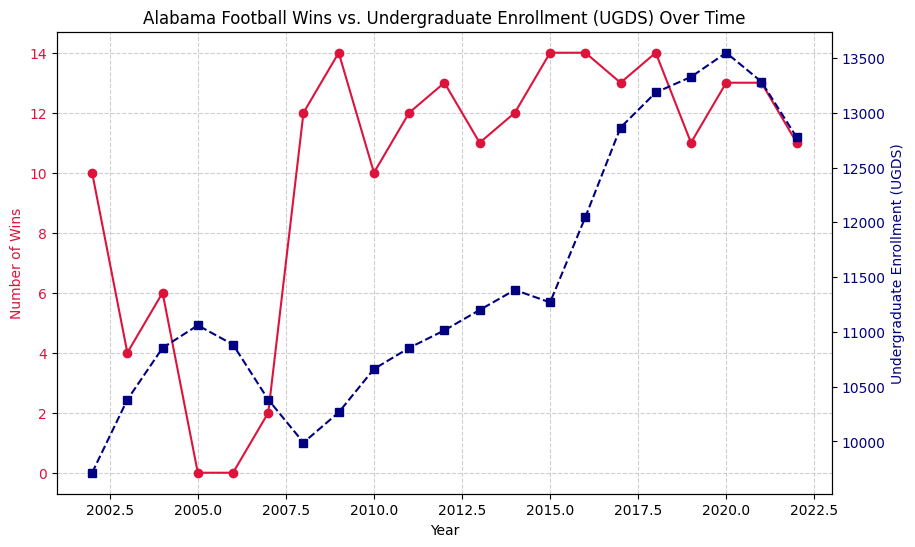

In [ ]:
alabama_data = merged_df[merged_df['team'] == 'Alabama']

alabama_data['year'] = pd.to_numeric(alabama_data['year'], errors='coerce')
alabama_data['UGDS'] = pd.to_numeric(alabama_data['UGDS'], errors='coerce')
alabama_data['won'] = pd.to_numeric(alabama_data['won'], errors='coerce')

alabama_data = alabama_data.dropna(subset=['year', 'UGDS', 'won'])
 
alabama_data = alabama_data.sort_values(by='year')

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot wins over time
ax1.plot(alabama_data['year'], alabama_data['won'], marker='o', linestyle='-', color='crimson', label='Wins')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Wins', color='crimson')
ax1.tick_params(axis='y', labelcolor='crimson')

# Create a second y-axis for UGDS
ax2 = ax1.twinx()
ax2.plot(alabama_data['year'], alabama_data['UGDS'], marker='s', linestyle='--', color='navy', label='UGDS')
ax2.set_ylabel('Undergraduate Enrollment (UGDS)', color='navy')
ax2.tick_params(axis='y', labelcolor='navy')

# Title and Grid
plt.title('Alabama Football Wins vs. Undergraduate Enrollment (UGDS) Over Time')
ax1.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()


C:\Users\potat\AppData\Local\Temp\ipykernel_8756\4214521694.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alabama_data['year'] = pd.to_numeric(alabama_data['year'], errors='coerce')
C:\Users\potat\AppData\Local\Temp\ipykernel_8756\4214521694.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alabama_data['UGDS'] = pd.to_numeric(alabama_data['UGDS'], errors='coerce')
C:\Users\potat\AppData\Local\Temp\ipykernel_8756\4214521694.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

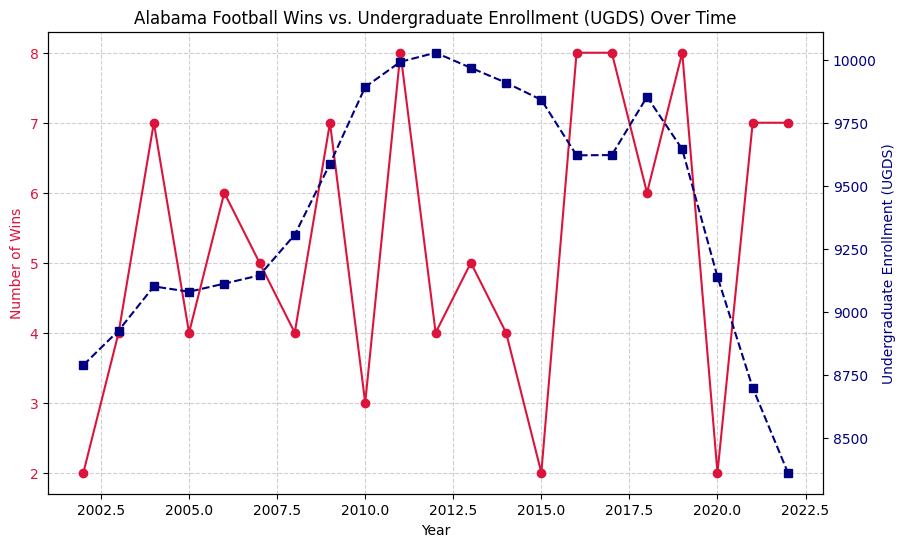

In [ ]:
alabama_data = merged_df[merged_df['team'] == 'Wyoming']

# Ensure 'year', 'UGDS', and 'wins' columns are numeric
alabama_data['year'] = pd.to_numeric(alabama_data['year'], errors='coerce')
alabama_data['UGDS'] = pd.to_numeric(alabama_data['UGDS'], errors='coerce')
alabama_data['won'] = pd.to_numeric(alabama_data['won'], errors='coerce')

# Drop rows with missing values in 'year', 'UGDS', or 'wins'
alabama_data = alabama_data.dropna(subset=['year', 'UGDS', 'won'])

# Sort data by year for proper plotting
alabama_data = alabama_data.sort_values(by='year')

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot wins over time
ax1.plot(alabama_data['year'], alabama_data['won'], marker='o', linestyle='-', color='crimson', label='Wins')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Wins', color='crimson')
ax1.tick_params(axis='y', labelcolor='crimson')

# Create a second y-axis for UGDS
ax2 = ax1.twinx()
ax2.plot(alabama_data['year'], alabama_data['UGDS'], marker='s', linestyle='--', color='navy', label='UGDS')
ax2.set_ylabel('Undergraduate Enrollment (UGDS)', color='navy')
ax2.tick_params(axis='y', labelcolor='navy')

# Title and Grid
plt.title('Wyoming Football Wins vs. Undergraduate Enrollment (UGDS) Over Time')
ax1.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()

In [31]:
merged_df.to_csv("merged_data.csv", index=False)